In [2]:
import warnings
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401
import torch
import torch.distributions as D
from flow_matching.path import AffineProbPath

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from flow_matching.utils import gradient

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from torch import Tensor, nn

warnings.filterwarnings("ignore", category=UserWarning, module="torch")

plt.style.use(["science"])

torch.manual_seed(42)
device = torch.device("cpu")

## Dataset

In [4]:
weight = 0.25
mixture_distribution = D.Categorical(torch.tensor(4 * [weight]))
mu = torch.tensor([[3, 3], [-3, 3], [-3, -3], [3, -3]], dtype=torch.float32)
covariances = torch.tensor(
    [
        [[0.5, 0.0], [0.0, 0.5]],
        [[0.5, 0.0], [0.0, 0.5]],
        [[0.5, 0.0], [0.0, 0.5]],
        [[0.5, 0.0], [0.0, 0.5]],
    ],
    dtype=torch.float32,
)


def generate_quad_gmm(num_samples):
    component_indices = mixture_distribution.sample((num_samples,))
    selected_means = torch.stack([mu[idx, :] for idx in component_indices])
    selected_covs = torch.stack([covariances[idx, :, :] for idx in component_indices])
    selected_components = D.MultivariateNormal(
        loc=selected_means, covariance_matrix=selected_covs
    )
    samples = selected_components.sample()
    diff = samples - selected_means
    return samples, component_indices, torch.sqrt(torch.sum(diff**2, dim=-1)), diff

## Flow matching

Let's implement MeanFlow Matching here with a MI loss on the target.

In [5]:
class MLP(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 2, h),
            nn.ELU(),
            nn.Linear(h, h),
            nn.ELU(),
            nn.Linear(h, h),
            nn.ELU(),
            nn.Linear(h, dim),
        )

    def forward(self, t: Tensor, x_t: Tensor, y: Tensor) -> Tensor:
        if t.ndim == 0:
            t = t.expand(x_t.shape[0], 1)

        elif t.ndim == 1:
            t = t.unsqueeze(1)

        if x_t.ndim == 1:
            x_t = x_t.unsqueeze(1)

        if y.ndim == 1:
            y = y.unsqueeze(1)

        return self.net(torch.cat((x_t, y, t), -1))


# training arguments
lr = 0.0005
batch_size = 256
iterations = 20001 #50001
print_every = 1000

# velocity field model init
vf = MLP(dim=2, h=256).to(device)
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

'''vf.load_state_dict(torch.load("./vf.pth", weights_only=True))'''
# init optimizer
optimizer = torch.optim.Adam(vf.parameters(), lr=lr)

# train
start_time = time.time()
for i in range(iterations):
    optimizer.zero_grad()

    x_1, y, _, _ = generate_quad_gmm(batch_size)
    x_1 = Tensor(x_1).to(device)
    y = Tensor(y).to(device)

    # switch the conditional vectors.
    y_uncond = torch.ones_like(y)*-1 #Tensor(y).to(device)
    #mask = torch.rand(x_1.shape[0]) < 0.5

    #y[mask] = Tensor([-1]).to(device)
    #y_uncond[~mask] = Tensor([-1]).to(device)

    x_0 = torch.randn_like(x_1).to(device)
    t = torch.rand(x_1.shape[0]).to(device)

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss

    ut = vf(x_t=path_sample.x_t, y=y, t=path_sample.t)
    ut_unconc = vf(x_t=path_sample.x_t, y=y_uncond, t=path_sample.t)

    
    '''with torch.set_grad_enabled(True):
            # 1) make a fresh leaf tensor for x_t
            x_t = path_sample.x_t.detach().clone()
            x_t.requires_grad_(True)

            # 2) sample Hutchinson noise
            z = (torch.randint(0, 2, x_t.shape, device=x_t.device) * 2 - 1).float()

            # 3) recompute velocities from x_t (do NOT detach)
            ut_cond = vf(x_t=x_t, y=y, t=path_sample.t)       # conditional
            ut_unct = vf(x_t=x_t, y=y_uncond, t=path_sample.t)       # unconditional

            diff = ut_cond.detach() - ut_unct

            # --- divergence for conditional field ---
            diff_dot_z = torch.einsum(
                "ij,ij->i",
                diff.flatten(start_dim=1),
                z.flatten(start_dim=1),
            )
            grad_diff = gradient(diff_dot_z, x_t)   # x_t is the leaf
            div_diff = torch.einsum(
                "ij,ij->i",
                grad_diff.flatten(start_dim=1),
                z.flatten(start_dim=1),
            )
            delta_t = t.view(-1, 1)
            mi = (div_diff).mean() # ((div_1 - div_2.detach())**2).mean()
            #print(f"MI: {mi}")
    '''

    loss = (
        torch.pow(ut_unconc - path_sample.dx_t, 2).mean() + \
        torch.pow(ut - path_sample.dx_t, 2).mean()
    )/2 #+ bound #_loss

    # optimizer step
    loss.backward()  # backward
    optimizer.step()  # update

    # log loss
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(
            f"| iter {i+1:6d} | {elapsed*1000/print_every:5.2f}  \
                ms/step | loss {loss.item():8.3f} "
        )
        #print(f"MI: {mi.mean()} +/- {mi.std()/torch.sqrt(torch.tensor(mi.shape[0]))}")
        start_time = time.time()

| iter   1000 |  3.85                  ms/step | loss    2.800 
| iter   2000 |  3.98                  ms/step | loss    2.797 
| iter   3000 |  3.84                  ms/step | loss    2.722 
| iter   4000 |  3.79                  ms/step | loss    2.677 
| iter   5000 |  3.93                  ms/step | loss    2.600 
| iter   6000 |  3.93                  ms/step | loss    2.683 
| iter   7000 |  3.76                  ms/step | loss    2.393 
| iter   8000 |  3.93                  ms/step | loss    2.623 
| iter   9000 |  3.96                  ms/step | loss    2.600 
| iter  10000 |  3.73                  ms/step | loss    2.834 
| iter  11000 |  3.75                  ms/step | loss    2.670 
| iter  12000 |  3.70                  ms/step | loss    2.569 
| iter  13000 |  3.73                  ms/step | loss    2.543 
| iter  14000 |  3.74                  ms/step | loss    2.564 
| iter  15000 |  3.75                  ms/step | loss    2.478 
| iter  16000 |  3.76                  m

In [6]:
from torch.func import jvp

In [74]:
class MLP(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64, num_classes=5, y_dim=1, t_dim=2):
        super().__init__()
        self.emb = nn.Embedding(num_classes, y_dim)
    
        self.net = nn.Sequential(
            nn.Linear(dim + y_dim + t_dim, h),
            nn.ELU(),
            nn.Linear(h, h),
            nn.ELU(),
            nn.Linear(h, h),
            nn.ELU(),
            nn.Linear(h, dim),
        )

    def forward(self, t: Tensor, r: Tensor, x_t: Tensor, y: Tensor) -> Tensor:
        if t.ndim == 0:
            t = t.expand(x_t.shape[0], 1)

        elif t.ndim == 1:
            t = t.unsqueeze(1)

        if x_t.ndim == 1:
            x_t = x_t.unsqueeze(1)

        if y.ndim == 1:
            y = y.unsqueeze(1)
            
        return self.net(torch.cat((x_t, y, t, r), -1))


# training arguments
lr = 0.0003
batch_size = 1024
iterations = 20001 #50001
print_every = 1000

# velocity field model init
vf = MLP(dim=2, h=256).to(device)
# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

'''vf.load_state_dict(torch.load("./vf.pth", weights_only=True))'''
# init optimizer
optimizer = torch.optim.Adam(vf.parameters(), lr=lr)

ratio_r_not_equal_t = 0.25

# train
start_time = time.time()
for i in range(iterations):
    optimizer.zero_grad()

    x_1, y, _, _ = generate_quad_gmm(batch_size)
    x_1 = Tensor(x_1).to(device)
    y = Tensor(y).to(device)

    time_samples = torch.rand(batch_size, 2, device=device)
    sorted_samples, _ = torch.sort(time_samples, dim=1)
    r, t = sorted_samples[:, 0], sorted_samples[:, 1]
    
    fraction_equal = 1.0 - ratio_r_not_equal_t  # e.g., 0.75 means 75% of samples have r=t
    # Create a mask for samples where r should equal t
    equal_mask = torch.rand(batch_size, device=device) < fraction_equal
    # Apply the mask: where equal_mask is True, set r=t (replace)
    r = torch.where(equal_mask, t, r)

    r = r.unsqueeze(-1)
    t = t.unsqueeze(-1)

    x_0 = torch.randn_like(x_1).to(device) # e
    z = (1 - t) * x_1 + t * x_0
    v = x_0 - x_1

    K = 4
    mask = torch.rand(x_1.shape[0]) < 0.5
    y[mask] = Tensor([K]).to(device)
    y_id = y.long()

    y_feat = vf.emb(y_id)                

    def fn(z, cur_r, cur_t):
        return vf(x_t=z, r=cur_r, t=cur_t, y=y_feat)
    
    u, dudt = jvp(fn, (z, r, t), (v, torch.zeros_like(r), torch.ones_like(t)))

    u_tgt = v - (t - r) * dudt
    error = u - u_tgt.detach()  

    loss = torch.sum(error**2, dim=1).mean()
    # optimizer step
    loss.backward()  # backward
    optimizer.step()  # update

    # log loss
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(
            f"| iter {i+1:6d} | {elapsed*1000/print_every:5.2f}  \
                ms/step | loss {loss.item():8.3f} "
        )
        #print(f"MI: {mi.mean()} +/- {mi.std()/torch.sqrt(torch.tensor(mi.shape[0]))}")
        start_time = time.time()

| iter   1000 | 13.05                  ms/step | loss   13.571 
| iter   2000 | 17.17                  ms/step | loss   11.602 
| iter   3000 | 16.50                  ms/step | loss   17.062 
| iter   4000 | 15.31                  ms/step | loss   16.398 
| iter   5000 | 15.54                  ms/step | loss   17.257 
| iter   6000 | 14.41                  ms/step | loss   21.038 
| iter   7000 | 15.38                  ms/step | loss   18.148 
| iter   8000 | 15.39                  ms/step | loss   20.713 
| iter   9000 | 14.67                  ms/step | loss   19.597 
| iter  10000 | 14.23                  ms/step | loss   18.045 
| iter  11000 | 17.27                  ms/step | loss   16.571 
| iter  12000 | 16.18                  ms/step | loss   21.162 
| iter  13000 | 16.39                  ms/step | loss   19.887 
| iter  14000 | 16.85                  ms/step | loss   21.155 
| iter  15000 | 17.16                  ms/step | loss   18.261 
| iter  16000 | 16.55                  m

In [43]:
# Do not use...

import torch
import torch.nn as nn
from torch import Tensor
from torch.autograd.functional import jvp
import time

# ... (Keep your MLP class and setup exactly as is) ...

class MLP(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64, num_classes=5, y_dim=1, t_dim=2):
        super().__init__()
        self.emb = nn.Embedding(num_classes, y_dim)
    
        self.net = nn.Sequential(
            nn.Linear(dim + y_dim + t_dim, h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.GELU(),
            nn.Linear(h, dim),
        )

    def forward(self, t: Tensor, r: Tensor, x_t: Tensor, y: Tensor) -> Tensor:
        if t.ndim == 0:
            t = t.expand(x_t.shape[0], 1)

        elif t.ndim == 1:
            t = t.unsqueeze(1)

        if x_t.ndim == 1:
            x_t = x_t.unsqueeze(1)

        if y.ndim == 1:
            y = y.unsqueeze(1)
            
        return self.net(torch.cat((x_t, y, t, r), -1))

device = "cpu" #torch.device("mps")
# training arguments
lr = 0.0005
batch_size = 1024
print_every = 1000
iterations = 20001
ratio_r_not_equal_t = 0.75

# velocity field model init
vf = MLP(dim=2, h=512).to(device)
optimizer = torch.optim.AdamW(vf.parameters(), lr=lr)

start_time = time.time()

for i in range(iterations):
    optimizer.zero_grad()

    # 1. Data & Time Sampling
    x_1, y, _, _ = generate_quad_gmm(batch_size)
    x_1 = Tensor(x_1).to(device)
    y = Tensor(y).to(device)

    time_samples = torch.rand(batch_size, 2, device=device)
    sorted_samples, _ = torch.sort(time_samples, dim=1)
    r, t = sorted_samples[:, 0], sorted_samples[:, 1]
    
    fraction_equal = 1.0 - ratio_r_not_equal_t 
    equal_mask = torch.rand(batch_size, device=device) < fraction_equal
    r = torch.where(equal_mask, t, r)

    r = r.unsqueeze(-1)
    t = t.unsqueeze(-1)

    # 2. Path Construction
    x_0 = torch.randn_like(x_1).to(device)
    z = (1 - t) * x_1 + t * x_0
    v = x_0 - x_1

    # 3. Label Embedding
    y_id = y.long()
    y_feat = vf.emb(y_id)

    # =========================================================
    # 4. The Fix: Match Reference Pattern
    # =========================================================

    # A. Standard Forward Pass (Connects to Optimizer)
    # We calculate 'u' here so gradients can flow back to weights later.

    K = 4
    y_feat_uncond = vf.emb(torch.full_like(y, fill_value=K).long())

    u_cond = vf(t, r, z, y_feat)
    u_uncond = vf(t, r, z, y_feat_uncond)

    # B. Define Wrapper for JVP
    # This wrapper captures 'y_feat' as a constant (closed over), 
    # so JVP only sees (t, r, z) as inputs.
    def fn_for_jvp_cond(t_in, r_in, z_in):
        return vf(t_in, r_in, z_in, y_feat)
    
    def fn_for_jvp_uncond(t_in, r_in, z_in):
        return vf(t_in, r_in, z_in, y_feat_uncond)

    # C. Compute JVP (Only for the Target)
    # Primals: The values at which we evaluate derivatives
    primals = (t, r, z)
    
    # Tangents: Directions of change [dt=1, dr=0, dz=v]
    tangents = (torch.ones_like(t), torch.zeros_like(r), v)
    
    # We ignore the first return (u_jvp) because we calculated 'u' in step A.
    # We only need dudt (the acceleration).
    _, dudt = jvp(fn_for_jvp_cond, primals, tangents)
    
    # =========================================================
    # 5. Loss Calculation
    # Taylor expansion: u(r) approx u(t) - (t-r)*u'(t)
    delta_t = t - r
    u_tgt = v - delta_t * dudt

    # CRITICAL: Detach the target. We don't optimize the target!
    error_cond = u_cond - u_tgt.detach()
    error_uncond = u_uncond - u_tgt.detach()
    
    loss = torch.sum(error_cond**2, dim=1).mean() + torch.sum(error_uncond**2, dim=1).mean()
    
    loss.backward()
    optimizer.step()

    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(f"| iter {i+1:6d} | {elapsed*1000/print_every:5.2f} ms/step | loss {loss.item():8.3f}")
        start_time = time.time()

| iter   1000 | 39.51 ms/step | loss   12.572
| iter   2000 | 38.11 ms/step | loss   11.774
| iter   3000 | 38.48 ms/step | loss   12.657
| iter   4000 | 38.98 ms/step | loss   12.487
| iter   5000 | 39.30 ms/step | loss   12.830
| iter   6000 | 39.89 ms/step | loss   13.375
| iter   7000 | 41.00 ms/step | loss   12.581
| iter   8000 | 40.79 ms/step | loss   13.197
| iter   9000 | 40.27 ms/step | loss   12.393
| iter  10000 | 40.49 ms/step | loss   12.747
| iter  11000 | 37.14 ms/step | loss   13.158
| iter  12000 | 35.73 ms/step | loss   12.824
| iter  13000 | 34.88 ms/step | loss   13.073
| iter  14000 | 35.07 ms/step | loss   12.959
| iter  15000 | 34.98 ms/step | loss   12.048
| iter  16000 | 35.03 ms/step | loss   12.869
| iter  17000 | 35.00 ms/step | loss   13.035
| iter  18000 | 35.21 ms/step | loss   12.995
| iter  19000 | 35.28 ms/step | loss   12.005
| iter  20000 | 35.47 ms/step | loss   12.522


In [99]:
torch.save(vf.state_dict(), "./vf_MeanFlow.pt")

## Solving the Flow ODE

In [305]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **model_extras):
        return self.model(x_t=x, t=t, **model_extras)

wrapped_vf = WrappedModel(vf)

batch_size = 20000  # batch size
eps_time = 1e-2
T = torch.linspace(0, 1, 10)  # sample times
T = T.to(device=device)

# step size for ode solver
step_size = 0.01

eps_time = 1e-2
T = torch.linspace(0, 1, 20)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
y = torch.ones(batch_size, device=device).unsqueeze(1) * -1

solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class

In [200]:
with torch.set_grad_enabled(True):
    x_1, y, d, _ = generate_quad_gmm(20000)
    # source distribution is an isotropic gaussian
    gaussian_log_density = D.Independent(
        D.Normal(torch.zeros(2, device=device), torch.ones(2, device=device)), 1
    ).log_prob

    # compute log likelihood with unbiased hutchinson estimator, average over num_acc

    step_size = 0.01
    n_steps = 200

    # compute with exact divergence
    output_cond = solver.compute_likelihood(
        x_1=x_1,
        y=y,
        time_grid=torch.linspace(1, 0, n_steps),
        r = torch.tensor(0.).to(device),
        method="midpoint",
        step_size=None,
        exact_divergence=True,
        log_p0=gaussian_log_density,
        return_intermediates=True,
    )
    output_uncond = solver.compute_likelihood(
        x_1=x_1,
        y=torch.ones_like(y) * -1,
        time_grid=torch.linspace(1, 0, n_steps),
        r = torch.tensor(0.).to(device),
        method="midpoint",
        step_size=None,
        exact_divergence=True,
        log_p0=gaussian_log_density,
        return_intermediates=True,
    )

## Visualising the flow

/var/folders/hv/zwl2_8896870n46jsw6xybt80000gp/T/ipykernel_27171/225641309.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


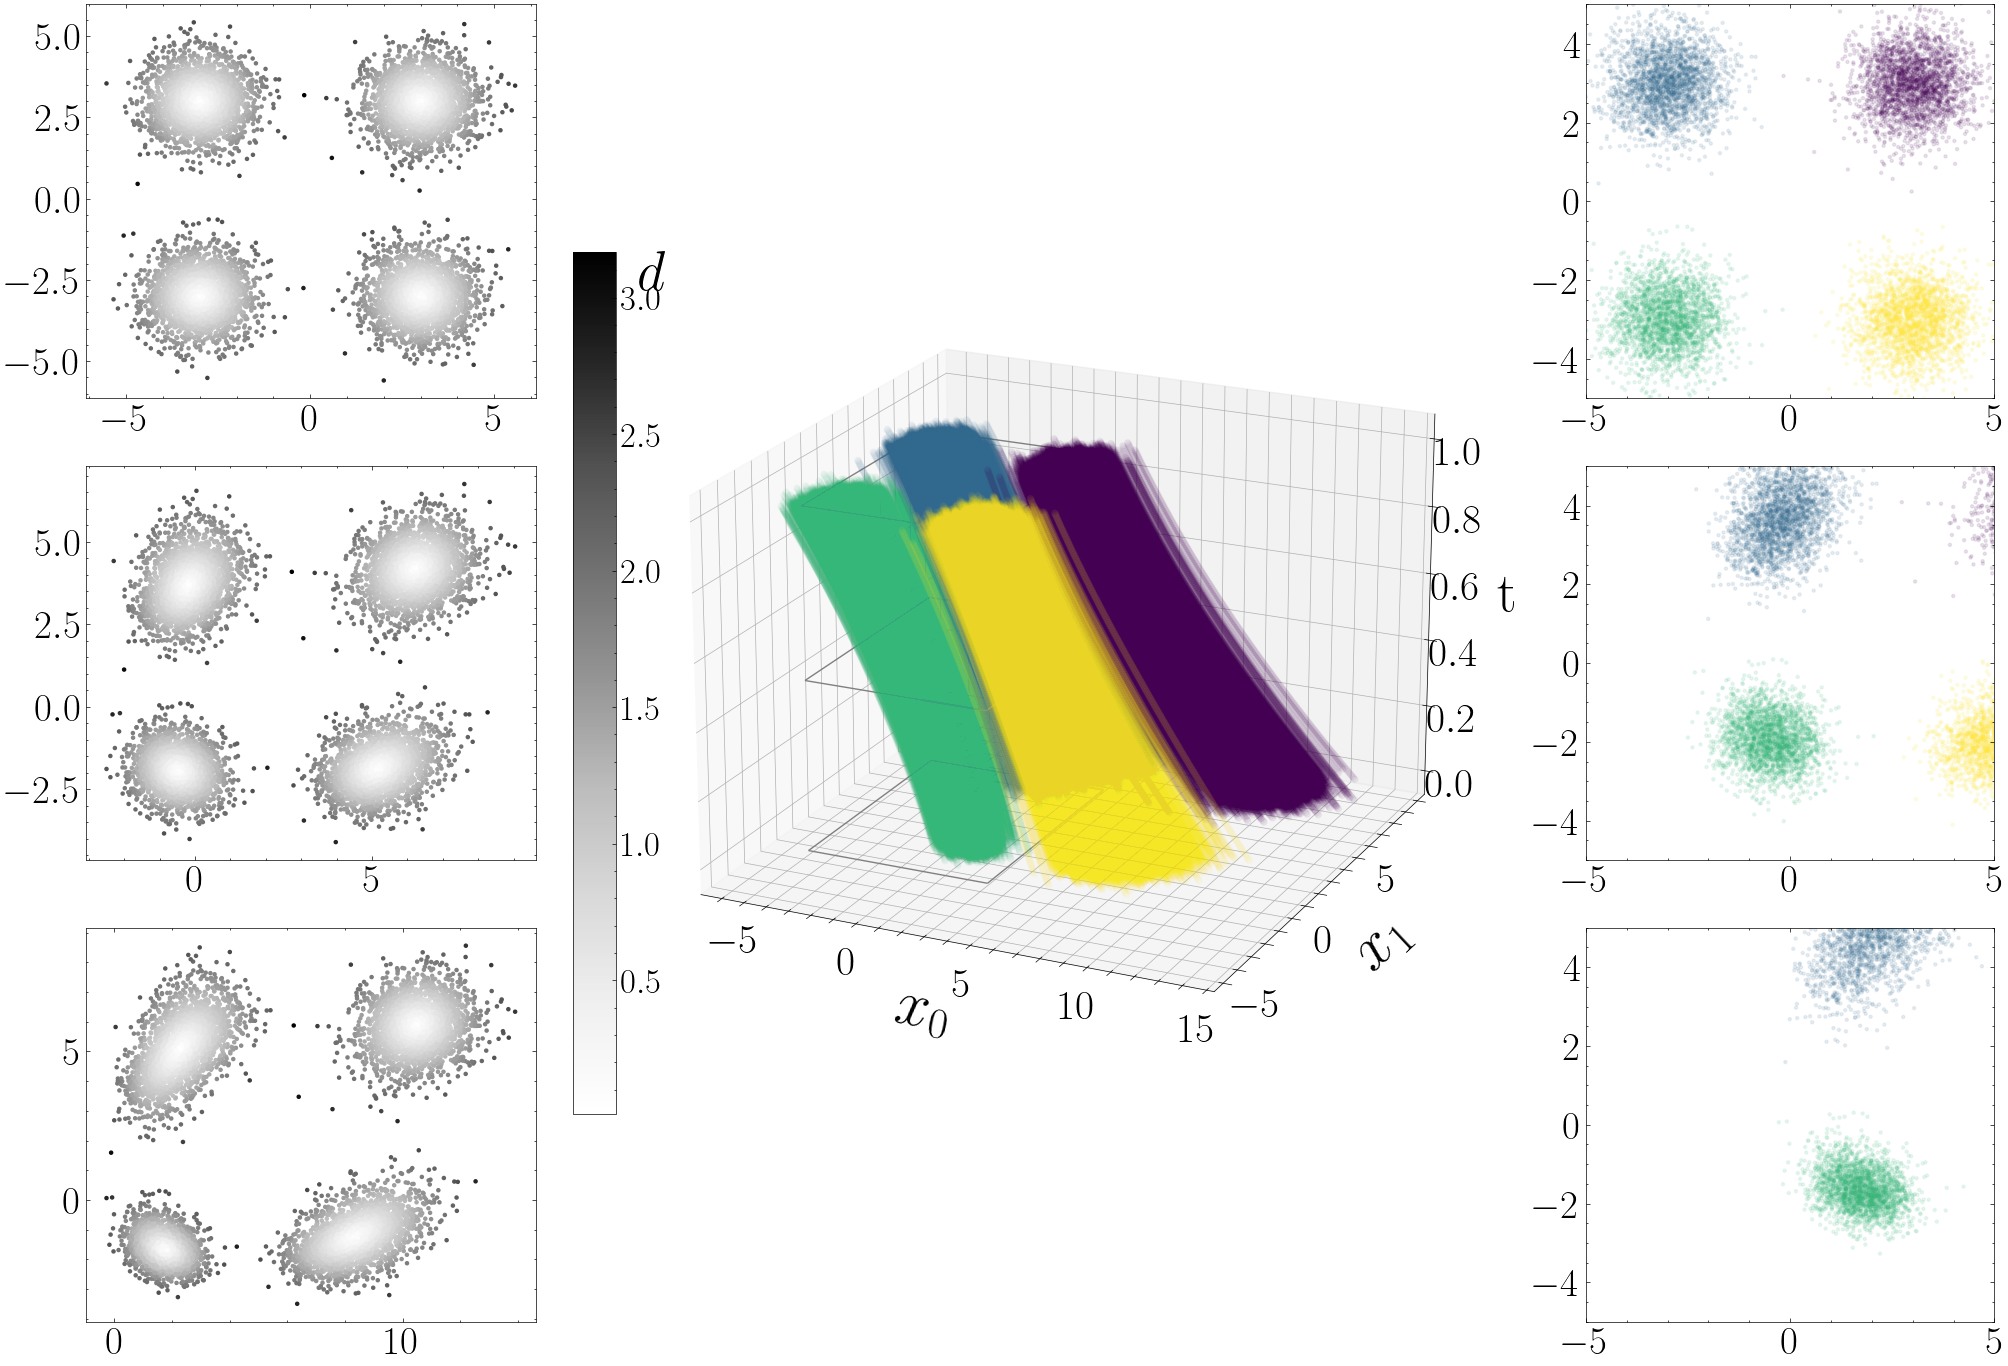

In [203]:
N = 10000
fig = plt.figure(figsize=(20, 14))

gs = GridSpec(
    3,
    3,  # 5 rows, 2 columns
    figure=fig,
    width_ratios=[1.1, 2.1, 1],
    height_ratios=[1, 1, 1],
)

# 3. Add the main 3D plot to the left, spanning all 5 rows and the first 2 columns
ax_3d = fig.add_subplot(gs[:, 1:2], projection="3d")

# --- Plotting code for the 3D axes (ax_3d) ---
for i in range(0, 200, 1):
    z = np.full_like(output_uncond["sol"][i][:N, 0].detach().numpy(), (200 - i) / 200)
    ax_3d.scatter(
        output_uncond["sol"][i][:N, 0].detach().numpy(),
        output_uncond["sol"][i][:N, 1].detach().numpy(),
        z,
        alpha=0.05,
        c=y[:N].detach().numpy(),
        s=20,
        cmap="viridis",
    )

for t in torch.linspace(0, 1, 3):
    plane_x = np.linspace(-4, 4, 10)
    plane_y = np.linspace(-4, 4, 10)
    X_plane, Y_plane = np.meshgrid(plane_x, plane_y)
    Z_plane = np.full_like(X_plane, t)
    ax_3d.plot_wireframe(
        X_plane, Y_plane, Z_plane, color="gray", rstride=10, cstride=10, linewidth=1.0
    )

ax_3d.set_xlabel("$x_0$", fontsize=45, labelpad=15)
ax_3d.set_ylabel("$x_1$", fontsize=45, labelpad=15)
ax_3d.set_zlabel("t", fontsize=40, labelpad=15)
ax_3d.tick_params(axis="x", labelsize=30)
ax_3d.tick_params(axis="y", labelsize=30)
ax_3d.tick_params(axis="z", labelsize=30)
ax_3d.view_init(elev=20, azim=-65)


time_indices = [0, 99, 199]
ax_shared_x = None

for i, time_idx in enumerate(time_indices):
    ax_2d = fig.add_subplot(gs[i, 2], sharex=ax_shared_x)

    time_val = (200 - time_idx) / 200.0
    x_data = output_uncond["sol"][time_idx][:N, 0].detach().numpy()
    y_data = output_uncond["sol"][time_idx][:N, 1].detach().numpy()

    ax_2d.scatter(
        x_data, y_data, alpha=0.1, s=5, c=y[:N].detach().numpy(), cmap="viridis"
    )
    ax_2d.set_xlim(-5, 5)  # Set consistent limits
    ax_2d.set_ylim(-5, 5)
    ax_2d.tick_params(axis="both", labelsize=28)

left_axes = []
for i, time_idx in enumerate(time_indices):
    ax_2d = fig.add_subplot(gs[i, 0], sharex=ax_shared_x)
    left_axes.append(ax_2d)
    time_val = (200 - time_idx) / 200.0
    x_data = output_uncond["sol"][time_idx][:N, 0].detach().numpy()
    y_data = output_uncond["sol"][time_idx][:N, 1].detach().numpy()
    ax_2d.tick_params(axis="both", labelsize=28)
    scatter = ax_2d.scatter(x_data, y_data, s=5, c=d[:N].detach().numpy(), cmap="Greys")

    first_ax = ax_2d
    first_scatter = scatter

if left_axes:
    # Use the list of axes here, and place it to the left of the plots
    cbar = fig.colorbar(scatter, ax=left_axes, shrink=0.8, pad=-0.2)
    cbar.set_label("$d$", fontsize=40, loc="top", rotation=0)
    cbar.ax.tick_params(labelsize=25)

# Adjust layout to prevent plots from overlapping
fig.tight_layout()
# plt.savefig("./figures/flow_matching_cond.png", dpi=300)
# plt.savefig("./uncond_2d_gaussian.pdf")

In [150]:
x_1, y, d, _ = generate_quad_gmm(3000)


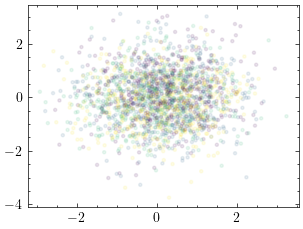

In [146]:
for num_steps in [1, 5, 10, 20, 100]:
    time_steps = torch.linspace(0, 1, num_steps + 1, device=device)
    y = y.to(device)  
    y_id = y.long()
    y_feat = vf.emb(y_id)

    x = x_1.clone().to(device)
    v_cond = []
    xs = []
    for i in range(num_steps):
        t_cur = time_steps[i]
        t_next = time_steps[i + 1]        
        
        v = vf(x_t=x, t=torch.ones_like(y).unsqueeze(-1)*t_cur, r=torch.ones_like(y).unsqueeze(-1)*t_next, y=y_feat)
        v_cond.append(v)
        dt = t_next - t_cur

        x = x + dt*v

        xs.append(x)
        
    v_cond = torch.stack(v_cond, dim=-1).view(-1, x_1.shape[0], x_1.shape[1])
    xs = torch.stack(xs, dim=-1).view(-1, x_1.shape[0], x_1.shape[1])

plt.scatter(
    x[:, 0].detach().cpu().numpy(), 
    x[:, 1].detach().cpu().numpy(),
    c=y.cpu(),
    s=5,
    alpha=0.1
)
'''plt.xlim(-4, 4)
plt.ylim(-4, 4)'''
plt.show()

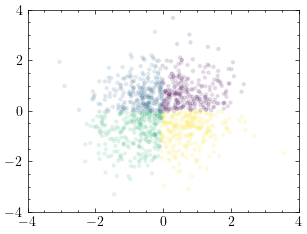

In [110]:
y = y.to(device)  

y_id = ((y*0.)+4).long()
y_feat = vf.emb(y_id)  

x = x_1.clone().to(device)

for i in range(num_steps):
    t_cur = time_steps[i]
    t_next = time_steps[i + 1]
    
    v = vf(x_t=x, t=torch.ones_like(y).unsqueeze(-1)*t_cur, r=torch.ones_like(y).unsqueeze(-1)*t_next, y=y_feat)

    dt = t_next - t_cur
    x = x + dt*v

#v_uncond = torch.stack(v_uncond, dim=-1).view(-1, x_1.shape[0], x_1.shape[1])

plt.scatter(
    x[:, 0].detach().cpu().numpy(), 
    x[:, 1].detach().cpu().numpy(),
    c=y.cpu(),
    s=5,
    alpha=0.1
)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [147]:
for num_steps in [1, 5, 10, 20, 100]:
    time_steps = torch.linspace(0, 1, num_steps + 1, device=device)
    y = y.to(device)  
    y_id = y.long()
    y_feat = vf.emb(y_id)

    x = x_1.clone().to(device)
    v_cond = []
    xs = []
    for i in range(num_steps):
        t_cur = time_steps[i]
        t_next = time_steps[i + 1]        
        
        v = vf(x_t=x, t=torch.ones_like(y).unsqueeze(-1)*t_cur, r=torch.ones_like(y).unsqueeze(-1)*t_next, y=y_feat)
        v_cond.append(v)
        dt = t_next - t_cur

        x = x + dt*v

        xs.append(x)
        
    #v_cond = torch.stack(v_cond, dim=-1).view(-1, x_1.shape[0], x_1.shape[1])
    #xs = torch.stack(xs, dim=-1).view(-1, x_1.shape[0], x_1.shape[1])


In [151]:
y = y.to(device)  
y_feat = vf.emb(y.long())  
y_feat_uncond = vf.emb(((y*0.)+4).long())  

MIs = []
MIs_uncs = []
steps = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100, 150, 200, 250, 300, 400, 500]
for num_steps in steps:
    time_steps = torch.linspace(0, 1, num_steps + 1, device=device)
    y = y.to(device)  
    y_id = y.long()
    y_feat = vf.emb(y_id)

    x = x_1.clone().to(device)
    v_cond = []
    xs = []
    for i in range(num_steps):
        t_cur = time_steps[i]
        t_next = time_steps[i + 1]        
        
        v = vf(x_t=x, t=torch.ones_like(y).unsqueeze(-1)*t_cur, r=torch.ones_like(y).unsqueeze(-1)*t_next, y=y_feat)
        v_cond.append(v)
        dt = t_next - t_cur

        x = x + v*dt
        xs.append(x)
        
    divs = []
    with torch.set_grad_enabled(True):
        # shared Hutchinson noise
        z = (torch.randint(0, 2, x_1.shape, device=device) * 2 - 1).float()
        for i in range(num_steps):
            
            v.requires_grad_(True)
            xt = xs[i].clone()
            t_cur = time_steps[i]
            t_next = time_steps[i + 1]

            t_in = torch.ones(xt.shape[0], 1, device=device) * t_cur

            # We set r = t_cur to ask for the instantaneous velocity at current time
            # (This recovers the vector field 'v' without Taylor adjustment)
            r_in = torch.ones(xt.shape[0], 1, device=device) * t_cur
            v_cond = vf(x_t=xt, t=t_in, r=r_in, y=y_feat)

            v_uncond = vf(x_t=xt, t=t_in, r=r_in, y=y_feat_uncond)
            v = v_cond - v_uncond
            
            # --- divergence for conditional ---
            v_dot_z = torch.einsum(
                "ij,ij->i", v.flatten(start_dim=1), z.flatten(start_dim=1)
            )

            grad = gradient(v_dot_z, xt)
            div = torch.einsum(
                "ij,ij->i",
                grad.flatten(start_dim=1),
                z.flatten(start_dim=1),
            )  # [B]
            divs.append(div)

    divs= torch.stack(divs, dim=0)   # [T, B]
    dt = (time_steps[-1] - time_steps[0]) / (time_steps.numel() - 1)
    #print(dt)
    # log-density ratio (per sample, at the final time grid[-1]):
    log_ratio_per_sample = dt * (0.5 * divs[0] + sum(divs[1:-1]) + 0.5 * divs[-1]) # (divs * dt).sum(dim=0)  # [B] 

    # Monte Carlo estimator of I(X_t; Y) at this t:
    mi_estimate = log_ratio_per_sample.mean()
    MIs.append(mi_estimate)
    MIs_uncs.append(log_ratio_per_sample.std()/(len(log_ratio_per_sample)**0.5))

MIs = torch.stack(MIs, dim=-1)

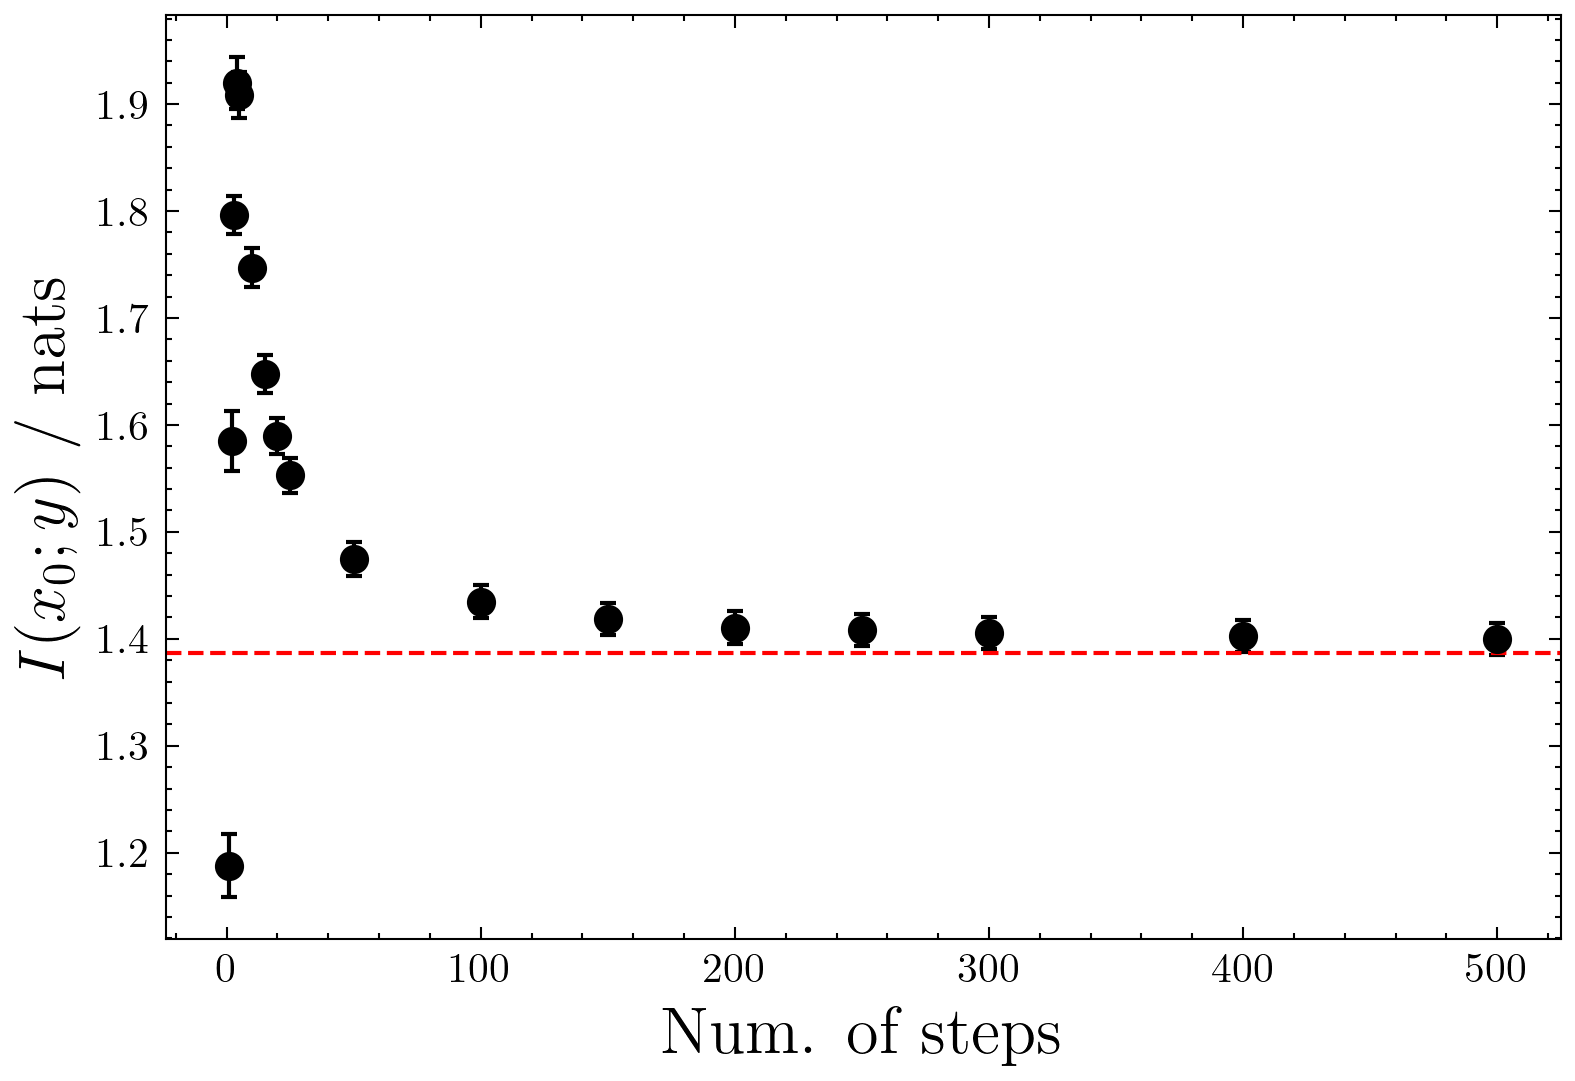

In [152]:
plt.figure(figsize=(6,4), dpi=300)
plt.errorbar(
    steps,
    MIs,
    yerr=MIs_uncs,
    fmt="o",
    capsize=2,
    c="black"
)
plt.ylabel(r"$I(x_0;y)$ / nats", fontsize=16)
plt.xlabel("Num. of steps", fontsize=16)
plt.axhline(np.log(4), ls="--", c="r")

In [112]:
# assuming uniform time grid from 0..1 or 1..0:
dt = (time_steps[-1] - time_steps[0]) / (time_steps.numel() - 1)
#print(dt)
# log-density ratio (per sample, at the final time grid[-1]):
log_ratio_per_sample = dt * (0.5 * divs[0] + sum(divs[1:-1]) + 0.5 * divs[-1]) # (divs * dt).sum(dim=0)  # [B] 

# Monte Carlo estimator of I(X_t; Y) at this t:
mi_estimate = log_ratio_per_sample.mean()
mi_estimate

tensor(-1.3724)

In [93]:
log_ratio_per_sample.std()/(len(log_ratio_per_sample)**0.5)

tensor(0.0184)

In [84]:
divs = []

for i in range(num_steps):
    z = (torch.randint(0, 2, xs[0].shape, device=device) * 2 - 1).float()
    xt = xs[i].detach().clone().requires_grad_(True)
    t_cur = time_steps[i]
    t_in = torch.full((xt.shape[0], 1), t_cur, device=device)
    r_in = t_in
    
    v_uncond = vf(x_t=xt, t=t_in, r=r_in, y=y_feat)
    v = v_cond[i] - v_uncond   # only OK if v_cond[i] depends on this xt!

    v_dot_z = (v.flatten(1) * z.flatten(1)).sum(dim=1)  # [B]

    grad = torch.autograd.grad(
        v_dot_z, xt,
        grad_outputs=torch.ones_like(v_dot_z),
        create_graph=False,
        retain_graph=False
    )[0]

    div = (grad.flatten(1) * z.flatten(1)).sum(dim=1)   # [B]
    divs.append(div.detach())

divs = torch.stack(divs, dim=0)

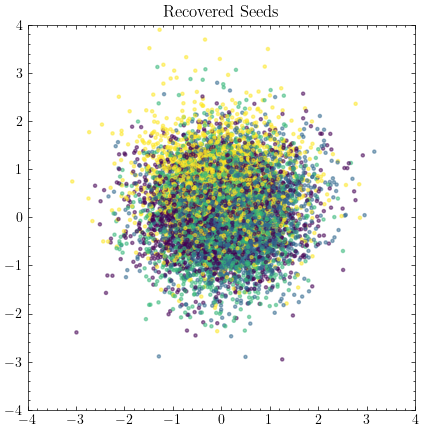

In [56]:
# 1. Define time steps from 0.0 (Data) to 1.0 (Noise)
num_steps = 5
time_steps = torch.linspace(0, 1, num_steps + 1, device=device)

# 2. Start from Data (x_1)
# Make sure x_1 is your actual data batch, not noise
x = x_1.clone() 

y_id = y.long()
y_feat = vf.emb(y_id)  

v_preds = []

# 3. Euler Integration Loop (Forward in time)
for i in range(num_steps):
    t_cur = time_steps[i]
    t_next = time_steps[i + 1]

    # Broadcast time scalars
    t_in = torch.ones(x.shape[0], 1, device=device) * t_cur
    
    # We set r = t_cur to ask for the instantaneous velocity at current time
    # (This recovers the vector field 'v' without Taylor adjustment)
    r_in = torch.ones(x.shape[0], 1, device=device) * t_cur
    
    # Predict velocity
    v_pred = vf(x_t=x, t=t_in, r=r_in, y=y_feat)
    v_preds.append(v_pred)
    # 4. Update Step
    # dt = t_next - t_cur (Positive value, e.g., +0.01)
    dt = t_next - t_cur
    
    # We move WITH the flow to go to noise
    x = x + dt * v_pred

# x is now at t=1.0 (The "Seed" / Base Distribution)

# Optional: Visualize the recovered seeds
# They should look like a standard Gaussian (Normal distribution)
plt.figure(figsize=(5,5))
plt.scatter(
    x[:, 0].detach().cpu().numpy(), 
    x[:, 1].detach().cpu().numpy(),
    c=y.cpu().numpy(),
    s=5,
    alpha=0.5
)
plt.title("Recovered Seeds")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

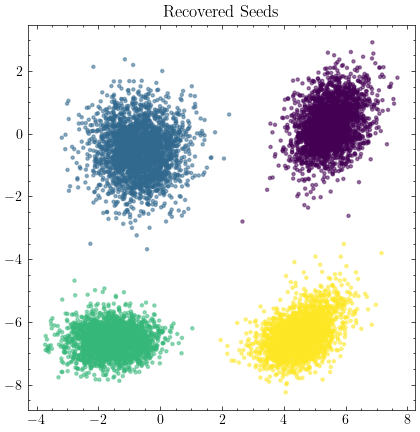

In [58]:
# 1. Define time steps from 0.0 (Data) to 1.0 (Noise)
num_steps = 5
time_steps = torch.linspace(0, 1, num_steps + 1, device=device)

# 2. Start from Data (x_1)
# Make sure x_1 is your actual data batch, not noise
x = x_1.clone() 

y_id = ((y * 0) + 4).long()
y_feat = vf.emb(y_id)  

# 3. Euler Integration Loop (Forward in time)
for i in range(num_steps):
    t_cur = time_steps[i]
    t_next = time_steps[i + 1]

    # Broadcast time scalars
    t_in = torch.ones(x.shape[0], 1, device=device) * t_cur
    
    # We set r = t_cur to ask for the instantaneous velocity at current time
    # (This recovers the vector field 'v' without Taylor adjustment)
    r_in = torch.ones(x.shape[0], 1, device=device) * t_cur
    
    # Predict velocity
    v_pred = vf(x_t=x, t=t_in, r=r_in, y=y_feat)
    
    # 4. Update Step
    # dt = t_next - t_cur (Positive value, e.g., +0.01)
    dt = t_next - t_cur
    
    # We move WITH the flow to go to noise
    x = x + dt * v_pred

# x is now at t=1.0 (The "Seed" / Base Distribution)

# Optional: Visualize the recovered seeds
# They should look like a standard Gaussian (Normal distribution)
plt.figure(figsize=(5,5))
plt.scatter(
    x[:, 0].detach().cpu().numpy(), 
    x[:, 1].detach().cpu().numpy(),
    c=y.cpu().numpy(),
    s=5,
    alpha=0.5
)
plt.title("Recovered Seeds")
#plt.xlim(-4, 4)
#plt.ylim(-4, 4)
plt.show()

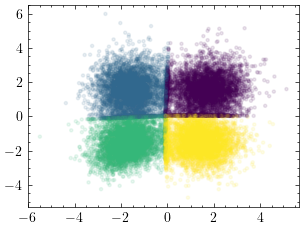

In [392]:
y_id = ((y * 0) + 4).long()
y_feat = vf.emb(y_id)  

for i in range(num_steps):
    t_cur = time_steps[i]
    t_next = time_steps[i + 1]

    if i == 0:
        x = x_1
    
    x = x + (t_cur - t_next)*vf(x_t=x, t=torch.ones_like(y).unsqueeze(-1)*t_cur, r=torch.ones_like(y).unsqueeze(-1)*t_next, y=y_feat)
    
plt.scatter(
    x[:, 0].detach().cpu().numpy(), 
    x[:, 1].detach().cpu().numpy(),
    c=y,
    s=5,
    alpha=0.1
)

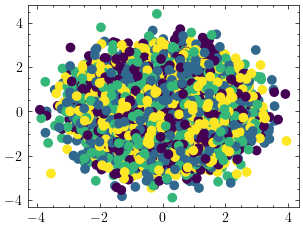

In [350]:
plt.scatter(
    e[:, 0], 
    e[:, 1],
    c=y
)

/var/folders/hv/zwl2_8896870n46jsw6xybt80000gp/T/ipykernel_27171/4165500913.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


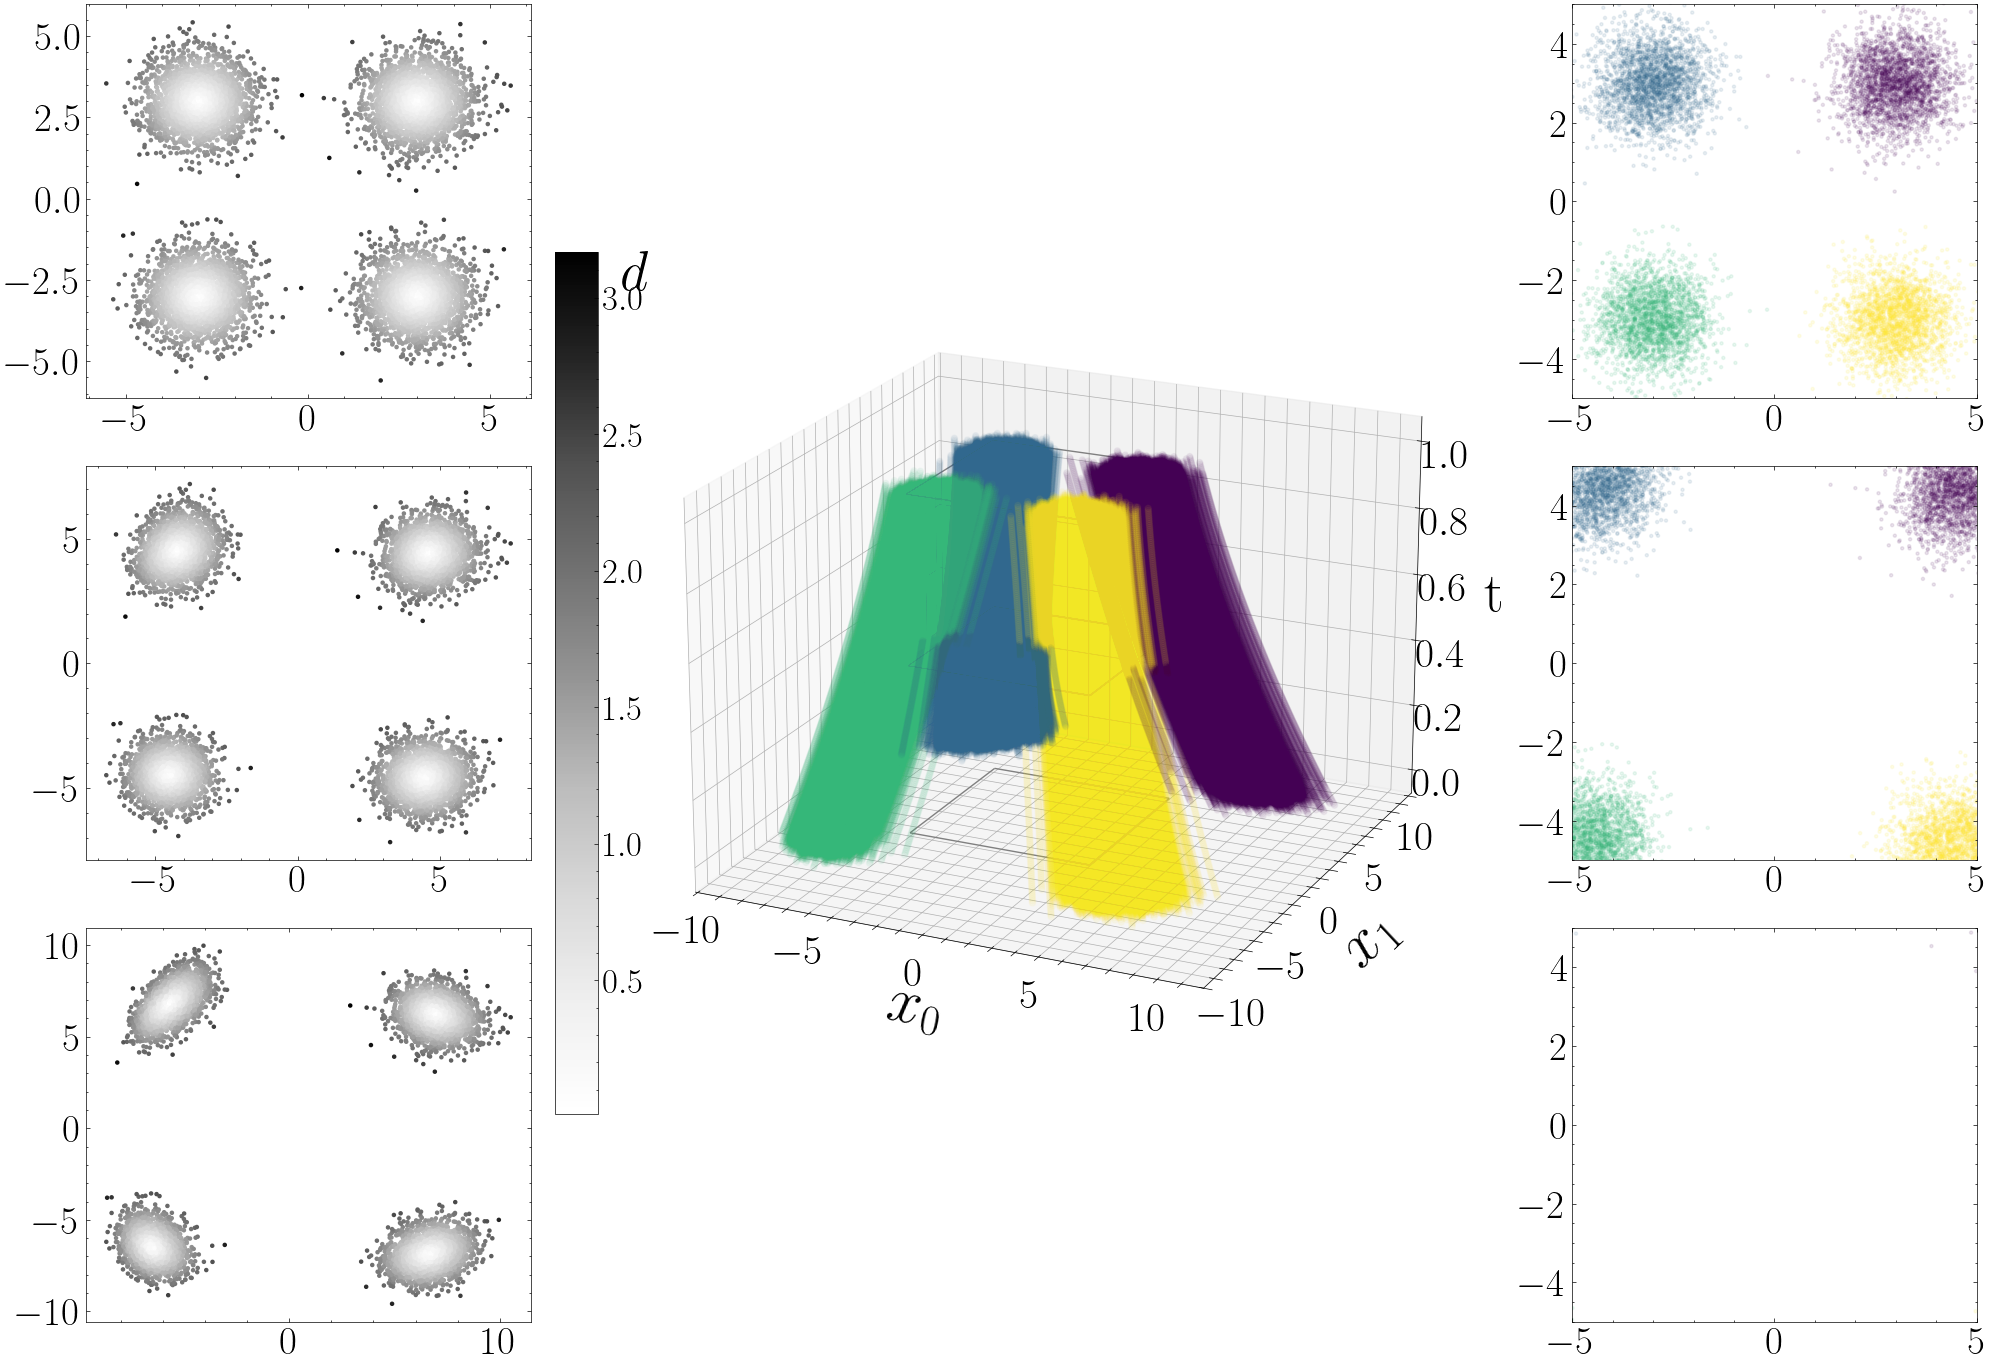

In [202]:
N = 10000

fig = plt.figure(figsize=(20, 14))

gs = GridSpec(3, 3, figure=fig, width_ratios=[1.1, 2.1, 1], height_ratios=[1, 1, 1])

ax_3d = fig.add_subplot(gs[:, 1:2], projection="3d")

for i in range(0, 200, 1):
    z = np.full_like(output_uncond["sol"][i][:N, 0].detach().numpy(), (200 - i) / 200)
    ax_3d.scatter(
        output_cond["sol"][i][:N, 0].detach().numpy(),
        output_cond["sol"][i][:N, 1].detach().numpy(),
        z,
        alpha=0.05,
        c=y[:N].detach().numpy(),
        s=20,
        cmap="viridis",
    )

for t in torch.linspace(0, 1, 3):
    plane_x = np.linspace(-4, 4, 10)
    plane_y = np.linspace(-4, 4, 10)
    X_plane, Y_plane = np.meshgrid(plane_x, plane_y)
    Z_plane = np.full_like(X_plane, t)
    ax_3d.plot_wireframe(
        X_plane, Y_plane, Z_plane, color="gray", rstride=10, cstride=10, linewidth=1.0
    )

ax_3d.set_xlabel("$x_0$", fontsize=45, labelpad=15)
ax_3d.set_ylabel("$x_1$", fontsize=45, labelpad=15)
ax_3d.set_zlabel("t", fontsize=40, labelpad=15)
ax_3d.tick_params(axis="x", labelsize=30)
ax_3d.tick_params(axis="y", labelsize=30)
ax_3d.tick_params(axis="z", labelsize=30)
ax_3d.view_init(elev=20, azim=-65)


time_indices = [0, 99, 199]
ax_shared_x = None

for i, time_idx in enumerate(time_indices):
    ax_2d = fig.add_subplot(gs[i, 2], sharex=ax_shared_x)

    time_val = (200 - time_idx) / 200.0
    x_data = output_cond["sol"][time_idx][:N, 0].detach().numpy()
    y_data = output_cond["sol"][time_idx][:N, 1].detach().numpy()

    ax_2d.scatter(
        x_data, y_data, alpha=0.1, s=5, c=y[:N].detach().numpy(), cmap="viridis"
    )
    ax_2d.set_xlim(-5, 5)
    ax_2d.set_ylim(-5, 5)
    ax_2d.tick_params(axis="both", labelsize=28)

left_axes = []
for i, time_idx in enumerate(time_indices):
    # Add a new subplot to the i-th row of the last column
    ax_2d = fig.add_subplot(gs[i, 0], sharex=ax_shared_x)
    left_axes.append(ax_2d)

    # Plot a 2D snapshot for that time
    time_val = (200 - time_idx) / 200.0
    x_data = output_cond["sol"][time_idx][:N, 0].detach().numpy()
    y_data = output_cond["sol"][time_idx][:N, 1].detach().numpy()
    ax_2d.tick_params(axis="both", labelsize=28)
    # fit kdes to this...

    scatter = ax_2d.scatter(x_data, y_data, s=5, c=d[:N].detach().numpy(), cmap="Greys")

    first_ax = ax_2d
    first_scatter = scatter

if left_axes:
    # Use the list of axes here, and place it to the left of the plots
    cbar = fig.colorbar(scatter, ax=left_axes, shrink=0.8, pad=-0.2)
    cbar.set_label("$d$", fontsize=40, loc="top", rotation=0)
    cbar.ax.tick_params(labelsize=25)

fig.tight_layout()

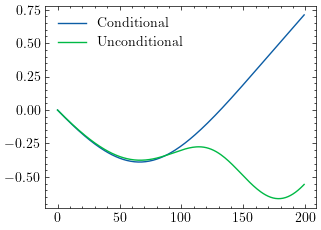

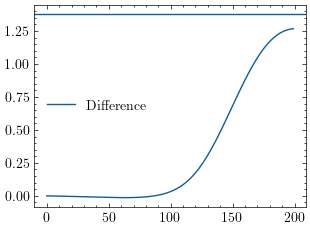

In [27]:
plt.plot(
    output_cond["log_det"].mean(axis=1),
    label="Conditional"
)
plt.plot(
    output_uncond["log_det"].mean(axis=1),
    label="Unconditional"
)
plt.legend()
plt.show()

plt.plot(
    (output_cond["log_det"] - output_uncond["log_det"]).mean(axis=1),
    label="Difference"
)
plt.axhline(1.38)
plt.legend()
plt.show()

# So the problem with this is that you need to eval the conditional position using the null token.

In [12]:
# Algorithm #1 

# Compute the positions from the conditional path - can do
# Compute the velocities at those points given the null vector - can do that
# Compute the divergences of the conditional velocities and the null vector velocities - broken

In [27]:
# Compare result velocity divergences with information in the Gaussian case.

In [99]:
from flow_matching.utils import gradient

In [89]:
sol = output_cond["sol"]          # [T, B, ...]
time_grid = torch.linspace(1,0,200) # [T] or whatever you used
T, B = sol.shape[0], sol.shape[1]

divs = []

with torch.set_grad_enabled(True):
    for i in range(T):
        xt = sol[i].detach().clone()   # [B, ...]
        xt.requires_grad_(True)

        t_i = time_grid[i]
        t_in = t_i.expand(B)           # adjust shape to vf's needs

        z = (torch.randint(0, 2, xt.shape, device=xt.device) * 2 - 1).float()

        ut = vf(x_t=xt, y=y, t=t_in)

        ut_dot_z = torch.einsum(
            "ij,ij->i",
            ut.flatten(start_dim=1),
            z.flatten(start_dim=1),
        )
        grad_ut_dot_z = gradient(ut_dot_z, xt)

        div = torch.einsum(
            "ij,ij->i",
            grad_ut_dot_z.flatten(start_dim=1),
            z.flatten(start_dim=1),
        )
        divs.append(div)

divs = torch.stack(divs, dim=0)   # [T, B]

# integral and log-prob shift
int_div = torch.trapz(divs, time_grid, dim=0)   # [B]

In [194]:
sol = output_cond["sol"]          # [T, B, ...]
time_grid = torch.linspace(1, 0, 200) # [T] or whatever you used
T, B = sol.shape[0], sol.shape[1]

divs_uncond = []

with torch.set_grad_enabled(True):
    for i in range(T):
        xt = sol[i].detach().clone()   # [B, ...]
        xt.requires_grad_(True)

        t_i = time_grid[i]
        t_in = t_i.expand(B)           # adjust shape to vf's needs

        z = (torch.randint(0, 2, xt.shape, device=xt.device) * 2 - 1).float()

        ut = vf(x_t=xt, y=torch.ones_like(y)*-1, t=t_in)

        ut_dot_z = torch.einsum(
            "ij,ij->i",
            ut.flatten(start_dim=1),
            z.flatten(start_dim=1),
        )
        grad_ut_dot_z = gradient(ut_dot_z, xt)

        div = torch.einsum(
            "ij,ij->i",
            grad_ut_dot_z.flatten(start_dim=1),
            z.flatten(start_dim=1),
        )
        divs_uncond.append(div)

divs_uncond = torch.stack(divs_uncond, dim=0)   # [T, B]

# integral and log-prob shift
int_div_uncond = torch.trapz(divs_uncond, time_grid, dim=0)   # [B]

'''log_p_t0 = log_p0(x0)    # wherever your base is
log_p_t1 = log_p_t0 - int_div'''

'log_p_t0 = log_p0(x0)    # wherever your base is\nlog_p_t1 = log_p_t0 - int_div'

In [15]:
torch.trapz(divs - divs_uncond, time_grid, dim=0).mean(), torch.trapz(divs - divs_uncond, time_grid, dim=0).std()

NameError: name 'divs_uncond' is not defined

In [12]:
T, B = output_cond["sol"].shape[0], output_cond["sol"].shape[1]  # [T, B, ...]
time_grid = torch.linspace(1., 0., T, device=output_cond["sol"].device)  # or whatever you used

div_cond_list = []
div_uncond_list = []

with torch.set_grad_enabled(True):
    for i in range(T):
        xt = output_cond["sol"][i].detach().clone()   # [B, ...]
        xt.requires_grad_(True)

        t_i = time_grid[i]
        t_in = t_i.expand(B)  # adjust to your vf signature

        # shared Hutchinson noise
        z = (torch.randint(0, 2, xt.shape, device=xt.device) * 2 - 1).float()

        # conditional and unconditional velocities
        u_cond = vf(x_t=xt, y=y, t=t_in)   # p_t(x|y)
        u_unct = vf(x_t=xt, y=torch.ones_like(y)*-1,  t=t_in)   # p_t(x)

        # --- divergence for conditional ---
        u_cond_dot_z = torch.einsum(
            "ij,ij->i", u_cond.flatten(start_dim=1), z.flatten(start_dim=1)
        )
        grad_cond = gradient(u_cond_dot_z, xt)
        div_cond = torch.einsum(
            "ij,ij->i",
            grad_cond.flatten(start_dim=1),
            z.flatten(start_dim=1),
        )  # [B]

        # --- divergence for unconditional (reuse xt & z) ---
        u_unct_dot_z = torch.einsum(
            "ij,ij->i", u_unct.flatten(start_dim=1), z.flatten(start_dim=1)
        )
        grad_unct = gradient(u_unct_dot_z, xt)
        div_unct = torch.einsum(
            "ij,ij->i",
            grad_unct.flatten(start_dim=1),
            z.flatten(start_dim=1),
        )  # [B]

        div_cond_list.append(div_cond)
        div_uncond_list.append(div_unct)

div_cond = torch.stack(div_cond_list, dim=0)   # [T, B]
div_unct = torch.stack(div_uncond_list, dim=0) # [T, B]

In [108]:
# div_cond, div_unct: [T, B]
time_grid = torch.linspace(0, 1., T, device=output_cond["sol"].device)  # or whatever you used

div_diff = div_cond - div_unct  # [T, B]

# assuming uniform time grid from 0..1 or 1..0:
dt = (time_grid[-1] - time_grid[0]) / (time_grid.numel() - 1)

# log-density ratio (per sample, at the final time grid[-1]):
log_ratio_per_sample = (div_diff * dt).sum(dim=0)  # [B]

# Monte Carlo estimator of I(X_t; Y) at this t:
mi_estimate = log_ratio_per_sample.mean()
mi_estimate

tensor(-1.3950)

In [107]:
log_ratio_per_sample.std()

tensor(0.8047)

In [103]:
(div_cond* dt).sum(dim=0).mean() #- (div_unct * dt).sum(dim=0).mean()  

tensor(-0.6548)

In [79]:
(div_unct * dt).sum(dim=0).mean()  

tensor(-0.7402)

In [ ]:
log_ratio_per_sample

tensor([-1.1252, -2.7363, -0.7584,  ..., -1.7478, -1.6214, -1.4244])

In [66]:
# This is the other way round than one would expect. 

# However, things are upside because the conditional is the uninformative prior on y given the conditioning.
# And the unconditional retains the information about y.
# I need to show why this is the case.

In [64]:
# div_cond, div_unct: [T, B]
time_grid = torch.linspace(0., 1., T, device=output_cond["sol"].device)  # or whatever you used

#div_diff = div_cond - div_unct  # [T, B]

# assuming uniform time grid from 0..1 or 1..0:
dt = (time_grid[-1] - time_grid[0]) / (time_grid.numel() - 1)

# log-density ratio (per sample, at the final time grid[-1]):
log_ratio_per_sample = (div_cond * dt).sum(dim=0)  # [B]

# Monte Carlo estimator of I(X_t; Y) at this t:
mi_estimate = (log_ratio_per_sample - gaussian_log_density(xt)).mean()
mi_estimate 

tensor(2.1580, grad_fn=<MeanBackward0>)

In [62]:
log_ratio_per_sample

tensor([-0.7946, -0.6098, -0.7634,  ..., -0.6318, -0.8295, -0.6634])

In [53]:
gaussian_log_density(xt)

tensor([-2.0243, -3.8857, -2.6113,  ..., -2.2225, -2.4743, -2.2120],
       grad_fn=<SumBackward1>)

In [27]:
log_ratio_per_sample.std()/len(log_ratio_per_sample)**(0.5)

tensor(0.0057)

In [58]:
int_div_diff = torch.trapz(div_cond, torch.flip(time_grid, dims=[0]), dim=0)  # [B]
mi_est = int_div_diff.mean()
mi_est

tensor(0.6546)

In [ ]:
# You should implement the divergences from scratch 
# It looks close to the probs but let's make sure.

# Classifer on the representations

In [15]:
accuracy = []
for i in range(len(output_cond["sol"])):
    x_train, x_test, y_train, y_test = train_test_split(
        output_cond["sol"][i], y, test_size=0.2, random_state=42
    )
    model = SVC(kernel="rbf", probability=True, random_state=42)
    model.fit(x_train, y_train)
    accuracy.append(model.predict_log_proba(x_test))

In [16]:
uncond_log_probs = []
for i in range(len(output_uncond["sol"])):
    x_train, x_test, y_train, y_test = train_test_split(
        output_uncond["sol"][i], y, test_size=0.2, random_state=42
    )
    model = SVC(kernel="rbf", probability=True, random_state=42)
    model.fit(x_train, y_train)
    uncond_log_probs.append(model.predict_log_proba(x_test))

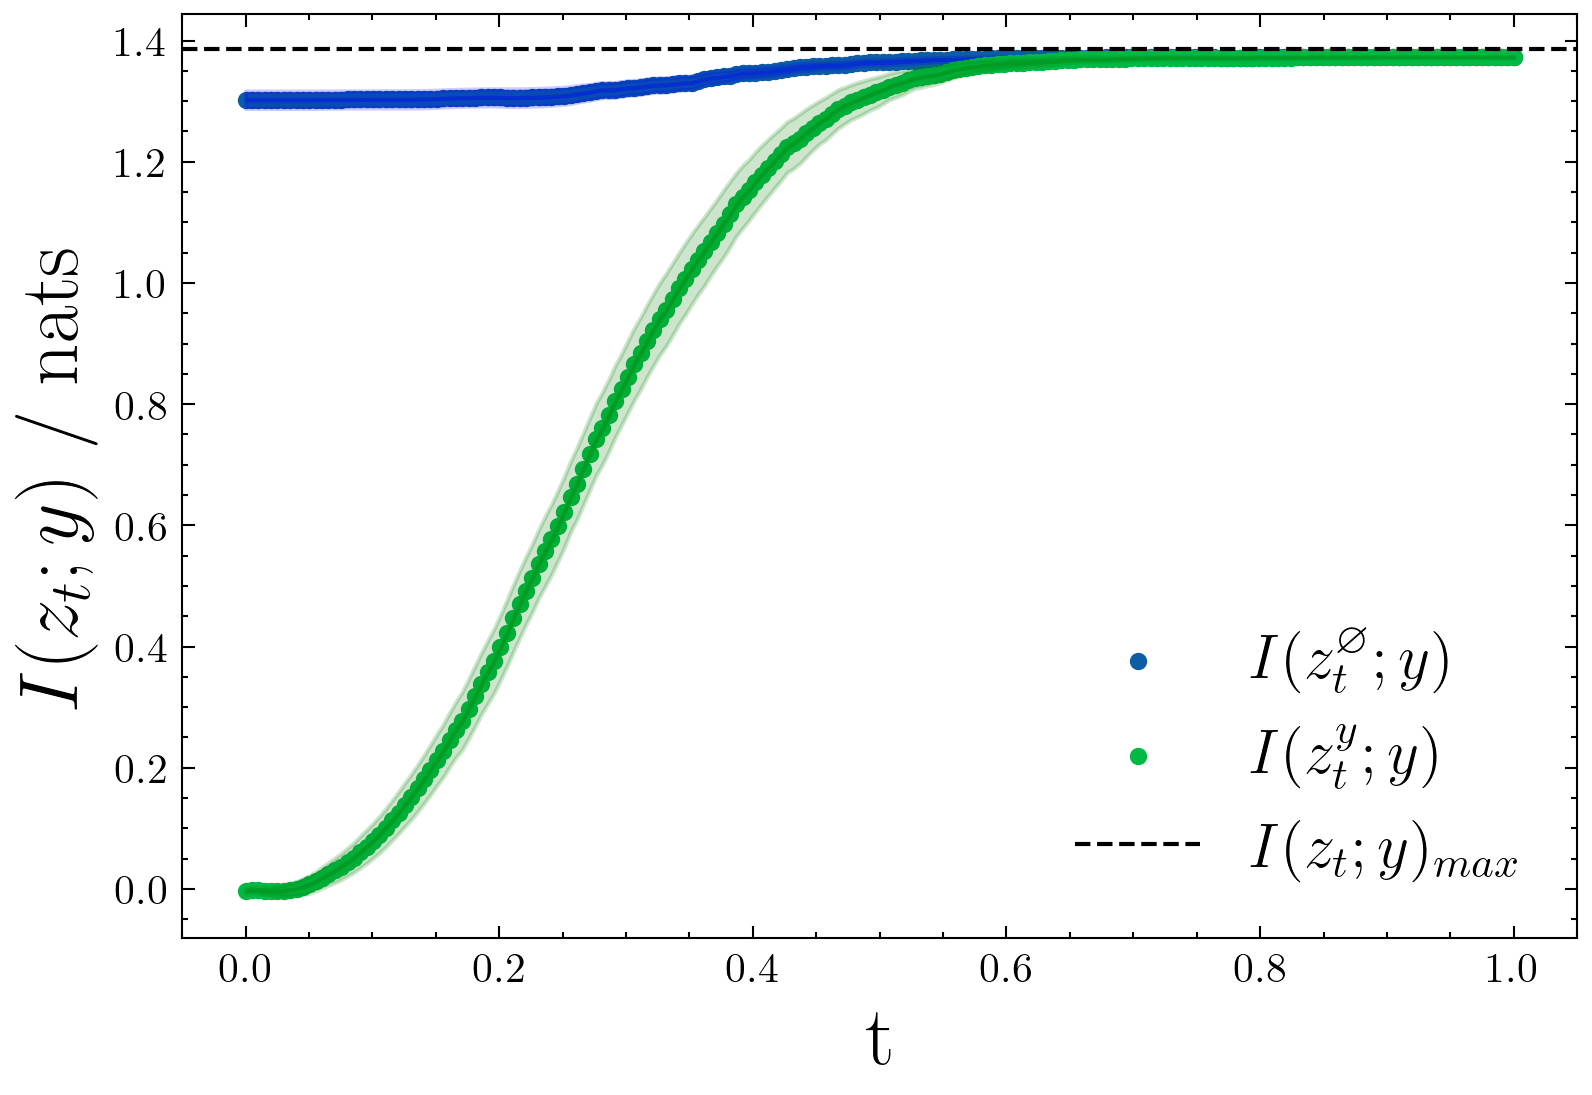

In [17]:
plt.figure(figsize=(6, 4), dpi=300)
uncond_log_probs_ = []
for log_prob in uncond_log_probs:
    uncond_log_probs_.append(log_prob[np.arange(log_prob.shape[0]), y_test.numpy()])

uncond_probs = np.stack(uncond_log_probs_) - np.log(1 / 4)
plt.scatter(
    torch.linspace(1, 0, uncond_probs.shape[0]),
    uncond_probs.mean(axis=-1),
    s=10,
    label=r"$I(z^{\varnothing}_t;y)$",
)
plt.fill_between(
    torch.linspace(1, 0, uncond_probs.shape[0]),
    uncond_probs.mean(axis=-1)
    + uncond_probs.std(axis=-1) / np.sqrt(uncond_probs.shape[0]),
    uncond_probs.mean(axis=-1),
    color="blue",
    alpha=0.2,
)
plt.fill_between(
    torch.linspace(1, 0, uncond_probs.shape[0]),
    uncond_probs.mean(axis=-1)
    - uncond_probs.std(axis=-1) / np.sqrt(uncond_probs.shape[0]),
    uncond_probs.mean(axis=-1),
    color="blue",
    alpha=0.2,
)

cond_log_probs = []

for log_prob in accuracy:
    cond_log_probs.append(
        log_prob[np.arange(log_prob.shape[0]), y_test.numpy()]
    )  # divide by prior

cond_probs = np.stack(cond_log_probs) - np.log(1 / 4)

plt.scatter(
    torch.linspace(1, 0, cond_probs.shape[0]),
    cond_probs.mean(axis=-1),
    s=10,
    label=r"$I(z^{y}_t;y)$",
)
plt.fill_between(
    torch.linspace(1, 0, cond_probs.shape[0]),
    cond_probs.mean(axis=-1) + cond_probs.std(axis=-1) / np.sqrt(cond_probs.shape[0]),
    cond_probs.mean(axis=-1),
    color="green",
    alpha=0.2,
)
plt.fill_between(
    torch.linspace(1, 0, cond_probs.shape[0]),
    cond_probs.mean(axis=-1) - cond_probs.std(axis=-1) / np.sqrt(cond_probs.shape[0]),
    cond_probs.mean(axis=-1),
    color="green",
    alpha=0.2,
)

plt.axhline(np.log(4), ls="--", c="black", label=r"$I(z_t;y)_{max}$")
plt.legend(fontsize=15)
plt.xlabel("t", fontsize=20)
plt.ylabel(r"$I(z_t;y)$ / nats", fontsize=20)
plt.show()

## Using omega to control the guidance

In [7]:
class ConditionedVelocityModelWrapper(nn.Module):
    """Wrapper around velocity model to inject month condition during inference.
    Implements classifier-free guidance according to the formula:
    u ← (1-w)*u_null + w*u_cond
    where:
    - u_null is the velocity with condition dropped
    - u_cond is the velocity with condition intact
    - w is the cfg_scale (default=1.0, which means no guidance)
    """

    def __init__(self, velocity_model, cfg_scale=1.0):
        super().__init__()
        self.velocity_model = velocity_model
        self.cfg_scale = cfg_scale

    def forward(self, x, t, **model_extras):
        """Forward pass with classifier-free guidance.

        Args:
            x: Input tensor (batch_size, ...)
            t: Time tensor (batch_size, ) or ()

        Returns:
            Predicted velocity with CFG applied if cfg_scale > 1.0
        """

        y = model_extras["y"]

        if self.cfg_scale == 1.0:
            return self.velocity_model(x_t=x, t=t, y=y)

        batch_size = x.shape[0]
        if t.dim() == 0:
            t = t.unsqueeze(0).expand(batch_size)

        v_cond = self.velocity_model(x_t=x, t=t, y=y)
        v_null = self.velocity_model(x_t=x, t=t, y=torch.ones_like(y) * -1)

        return (1 - self.cfg_scale) * v_null + self.cfg_scale * v_cond

In [10]:
omega_log_probs = []
for omega in np.linspace(-1, 1, 10):
    wrapped_vf = ConditionedVelocityModelWrapper(velocity_model=vf, cfg_scale=omega)

    solver = ODESolver(velocity_model=wrapped_vf)

    # compute with exact divergence
    output = solver.compute_likelihood(
        x_1=x_1,
        y=y,
        time_grid=torch.linspace(1, 0, n_steps),
        method="midpoint",
        step_size=None,
        exact_divergence=False,
        log_p0=gaussian_log_density,
        return_intermediates=True,
    )
    log_probs = []
    for i in range(len(output["sol"])):
        x_train, x_test, y_train, y_test = train_test_split(
            output["sol"][i], y, test_size=0.2, random_state=42
        )
        model = SVC(kernel="rbf", probability=True, random_state=42)
        model.fit(x_train, y_train)
        log_probs.append(model.predict_log_proba(x_test))
    omega_log_probs.append(log_probs)

In [11]:
omegas = np.linspace(-1, 1, 10)
omega_log_prob_series = []

for idx in range(len(omegas)):
    log_probs_ = []
    for log_prob in omega_log_probs[idx]:
        log_probs_.append(log_prob[np.arange(log_prob.shape[0]), y_test.numpy()])
    omega_log_prob_series.append(log_probs_)

In [15]:
omegas = np.linspace(-1, 1, 10)
n_steps = 200  # must match your time_grid
# Prepare a fixed split (and stratify if classification)
idx = np.arange(len(y))
y_np = y.detach().cpu().numpy() if hasattr(y, "detach") else np.asarray(y)
train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=y_np
)

omega_series = []  # will be list of arrays, each length n_steps

for omega in omegas:
    wrapped_vf = ConditionedVelocityModelWrapper(velocity_model=vf, cfg_scale=omega)
    solver = ODESolver(velocity_model=wrapped_vf)

    out = solver.compute_likelihood(
        x_1=x_1,
        y=y,
        time_grid=torch.linspace(1, 0, n_steps),
        method="midpoint",
        step_size=None,
        exact_divergence=False,
        log_p0=gaussian_log_density,
        return_intermediates=True,
    )

    # one scalar per timestep
    series = np.empty(len(out["sol"]), dtype=float)

    for t, X_t in enumerate(out["sol"]):
        Xt = X_t.detach().cpu().numpy() if hasattr(X_t, "detach") else np.asarray(X_t)

        X_train, X_test = Xt[train_idx], Xt[test_idx]
        y_train, y_test = y_np[train_idx], y_np[test_idx]

        clf = SVC(kernel="rbf", probability=True, random_state=42)
        clf.fit(X_train, y_train)

        lp = clf.predict_log_proba(X_test)  # (n_test, n_classes)
        # Map each row to the log-prob of its true class
        col_for_class = {c: j for j, c in enumerate(clf.classes_)}
        cols = np.array([col_for_class[yi] for yi in y_test])
        series[t] = lp[np.arange(len(y_test)), cols]  # .mean()

    omega_series.append(series)

omega_series = np.stack(omega_series)[:, ::-1]  # shape: (len(omegas), n_steps)

ValueError: setting an array element with a sequence.

In [32]:
omegas = np.linspace(-1, 1, 100)
n_steps = 200  # must match your time_grid

idx = np.arange(len(y))
y_np = y.detach().cpu().numpy() if hasattr(y, "detach") else np.asarray(y)
train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=y_np
)

omega_means, omega_stds = [], []  # one (mean/std) series per omega

for omega in omegas:
    wrapped_vf = ConditionedVelocityModelWrapper(velocity_model=vf, cfg_scale=omega)
    solver = ODESolver(velocity_model=wrapped_vf)

    out = solver.compute_likelihood(
        x_1=x_1,
        y=y,
        time_grid=torch.linspace(1, 0, n_steps),
        method="midpoint",
        step_size=None,
        exact_divergence=False,
        log_p0=gaussian_log_density,
        return_intermediates=True,
    )

    series_mean = np.empty(len(out["sol"]), dtype=float)
    series_std = np.empty(len(out["sol"]), dtype=float)

    for t, X_t in enumerate(out["sol"]):
        Xt = X_t.detach().cpu().numpy() if hasattr(X_t, "detach") else np.asarray(X_t)

        X_train, X_test = Xt[train_idx], Xt[test_idx]
        y_train, y_test = y_np[train_idx], y_np[test_idx]

        clf = SVC(kernel="rbf", probability=True, random_state=42)
        clf.fit(X_train, y_train)

        lp = clf.predict_log_proba(X_test)  # (n_test, n_classes)

        # True-class log-probs
        col_for_class = {c: j for j, c in enumerate(clf.classes_)}
        cols = np.array([col_for_class[yi] for yi in y_test])
        true_logps = lp[np.arange(len(y_test)), cols]

        infos = true_logps - np.log(1 / 4)

        series_mean[t] = infos.mean()
        series_std[t] = infos.std()  # std across test samples at timestep t

    omega_means.append(series_mean)
    omega_stds.append(series_std)

# shape: (len(omegas), n_steps); reverse time to match your convention
omega_means = np.stack(omega_means)[:, ::-1]
omega_stds = np.stack(omega_stds)[:, ::-1]

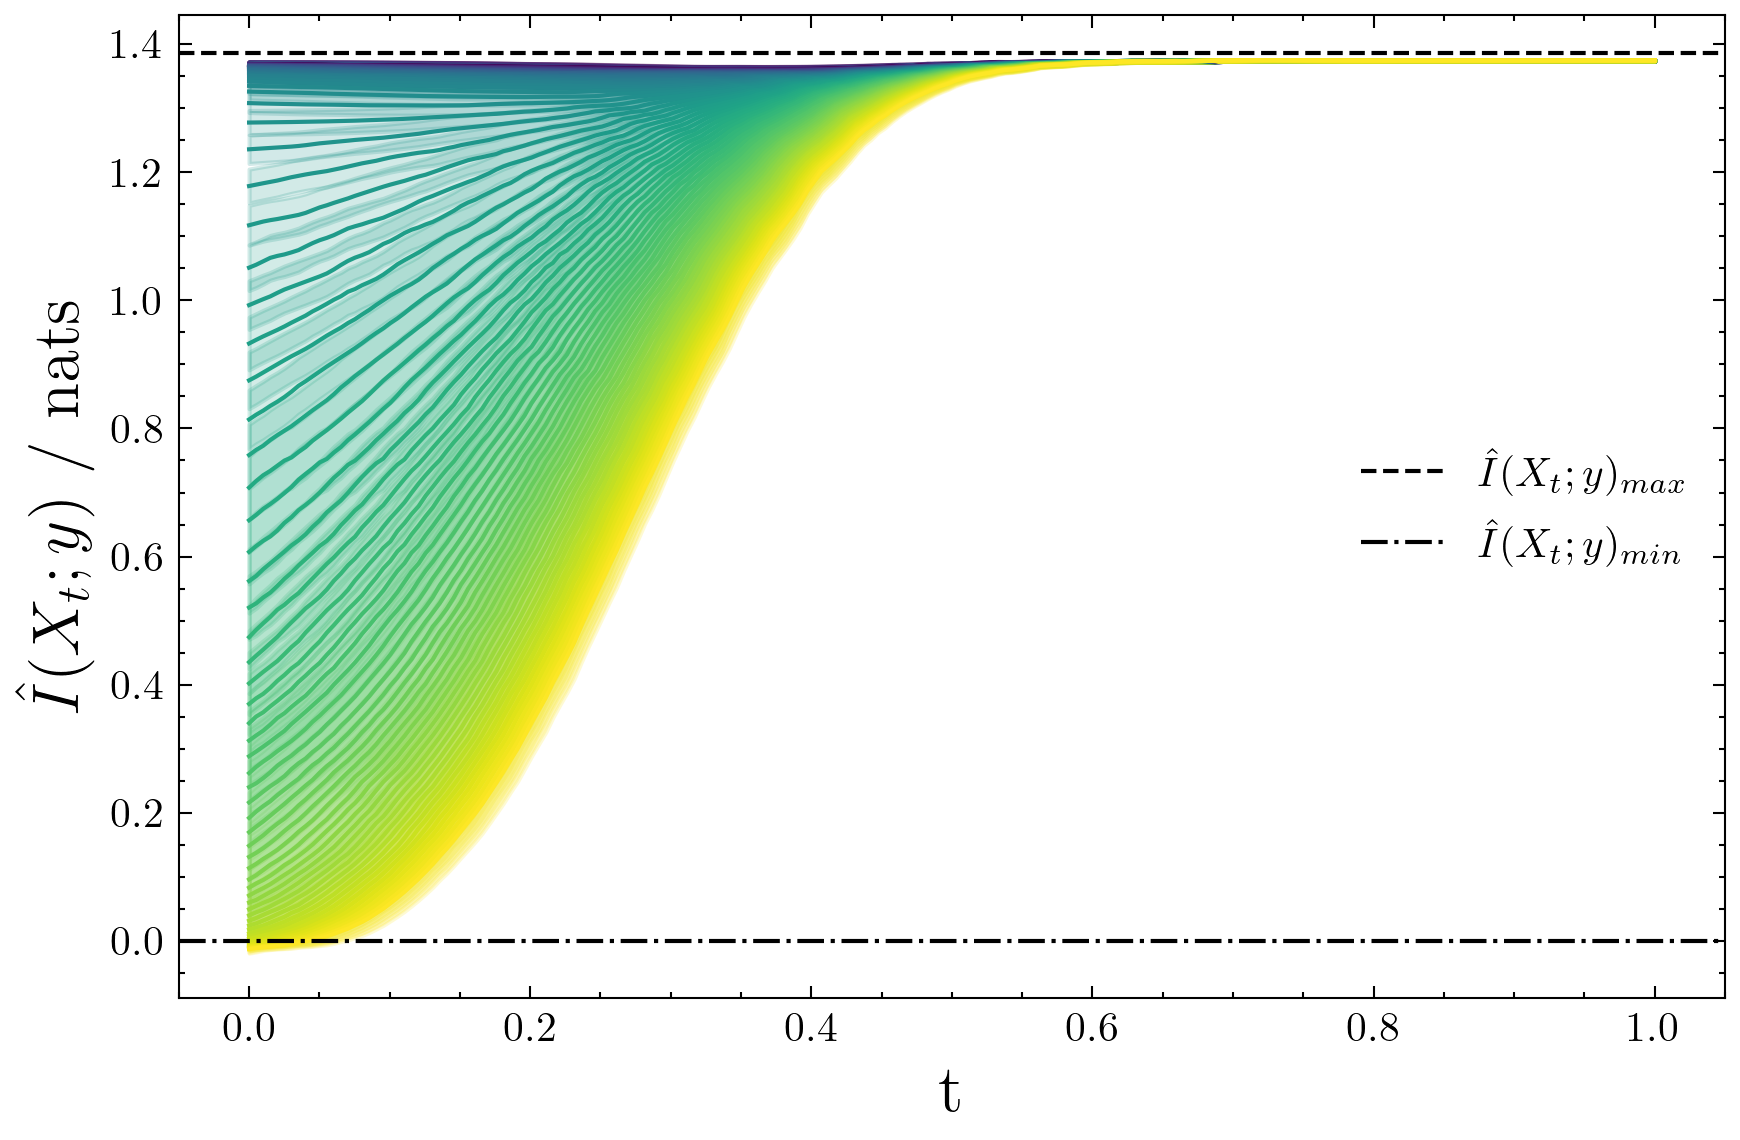

In [35]:
# --- Plot ---
plt.figure(figsize=(6, 4), dpi=300)

ts = np.linspace(0, 1, 200)

cmap = mpl.cm.viridis
colors = cmap(np.linspace(0, 1, len(omega_means)))  # one color per line

for k in range(len(omega_means)):
    plt.plot(ts, omega_means[k], color=colors[k])
    plt.fill_between(
        ts,
        omega_means[k] + omega_stds[k] / np.sqrt(len(omega_stds[k])),
        omega_means[k] - omega_stds[k] / np.sqrt(len(omega_stds[k])),
        color=colors[k],
        alpha=0.2,
    )
plt.xlabel("t", fontsize=16)
plt.ylabel(r"$\hat{I}(X_t;y)$ / nats", fontsize=16)

plt.axhline(-np.log(1 / 4), ls="--", c="black", label=r"$\hat{I}(X_t;y)_{max}$")
plt.axhline(0, ls="-.", c="black", label=r"$\hat{I}(X_t;y)_{min}$")
plt.tight_layout()
plt.legend()
plt.show()

## Linear regression: distance to component centre

In [36]:
x_1, y, d, diff = generate_quad_gmm(1000)

# --- split indices once (regression → no stratify) ---
idx = np.arange(len(diff))
diff_np = diff.detach().cpu().numpy() if hasattr(diff, "detach") else np.asarray(diff)
targets = diff_np[:, :2]  # columns 0 and 1

train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=None
)


# helper: one linear regressor (with scaling for stability)
def make_reg():
    return make_pipeline(LinearRegression())


omegas = np.linspace(-1, 1, 100)
n_steps = 200

# per-omega, per-timestep R² for each component
omega_series_dim0 = []  # shape after stack: (len(omegas), n_steps)
omega_series_dim1 = []

# (optional) keep fitted models if you want to inspect coefficients later
keep_models = False
models_dim0 = []  # list of lists: models_dim0[i_omega][t]
models_dim1 = []

for omega in omegas:
    wrapped_vf = ConditionedVelocityModelWrapper(velocity_model=vf, cfg_scale=omega)
    solver = ODESolver(velocity_model=wrapped_vf)

    out = solver.compute_likelihood(
        x_1=x_1,
        y=y,
        time_grid=torch.linspace(1, 0, n_steps),
        method="midpoint",
        step_size=None,
        exact_divergence=False,
        log_p0=gaussian_log_density,
        return_intermediates=True,
    )

    r2_d0 = np.empty(len(out["sol"]), dtype=float)
    r2_d1 = np.empty(len(out["sol"]), dtype=float)

    if keep_models:
        omega_models_d0 = []
        omega_models_d1 = []

    for t, X_t in enumerate(out["sol"]):
        Xt = X_t.detach().cpu().numpy() if hasattr(X_t, "detach") else np.asarray(X_t)

        X_train, X_test = Xt[train_idx], Xt[test_idx]
        y0_train, y0_test = targets[train_idx, 0], targets[test_idx, 0]
        y1_train, y1_test = targets[train_idx, 1], targets[test_idx, 1]

        # --- separate models ---
        reg0 = make_reg()
        reg1 = make_reg()

        reg0.fit(X_train, y0_train)
        reg1.fit(X_train, y1_train)

        y0_pred = reg0.predict(X_test)
        y1_pred = reg1.predict(X_test)

        r2_d0[t] = r2_score(y0_test, y0_pred)
        r2_d1[t] = r2_score(y1_test, y1_pred)

        if keep_models:
            omega_models_d0.append(reg0)
            omega_models_d1.append(reg1)

    omega_series_dim0.append(r2_d0)
    omega_series_dim1.append(r2_d1)

    if keep_models:
        models_dim0.append(omega_models_d0)
        models_dim1.append(omega_models_d1)

# reverse time like you did before
omega_series_dim0 = np.stack(omega_series_dim0)[:, ::-1]  # (len(omegas), n_steps)
omega_series_dim1 = np.stack(omega_series_dim1)[:, ::-1]  # (len(omegas), n_steps)

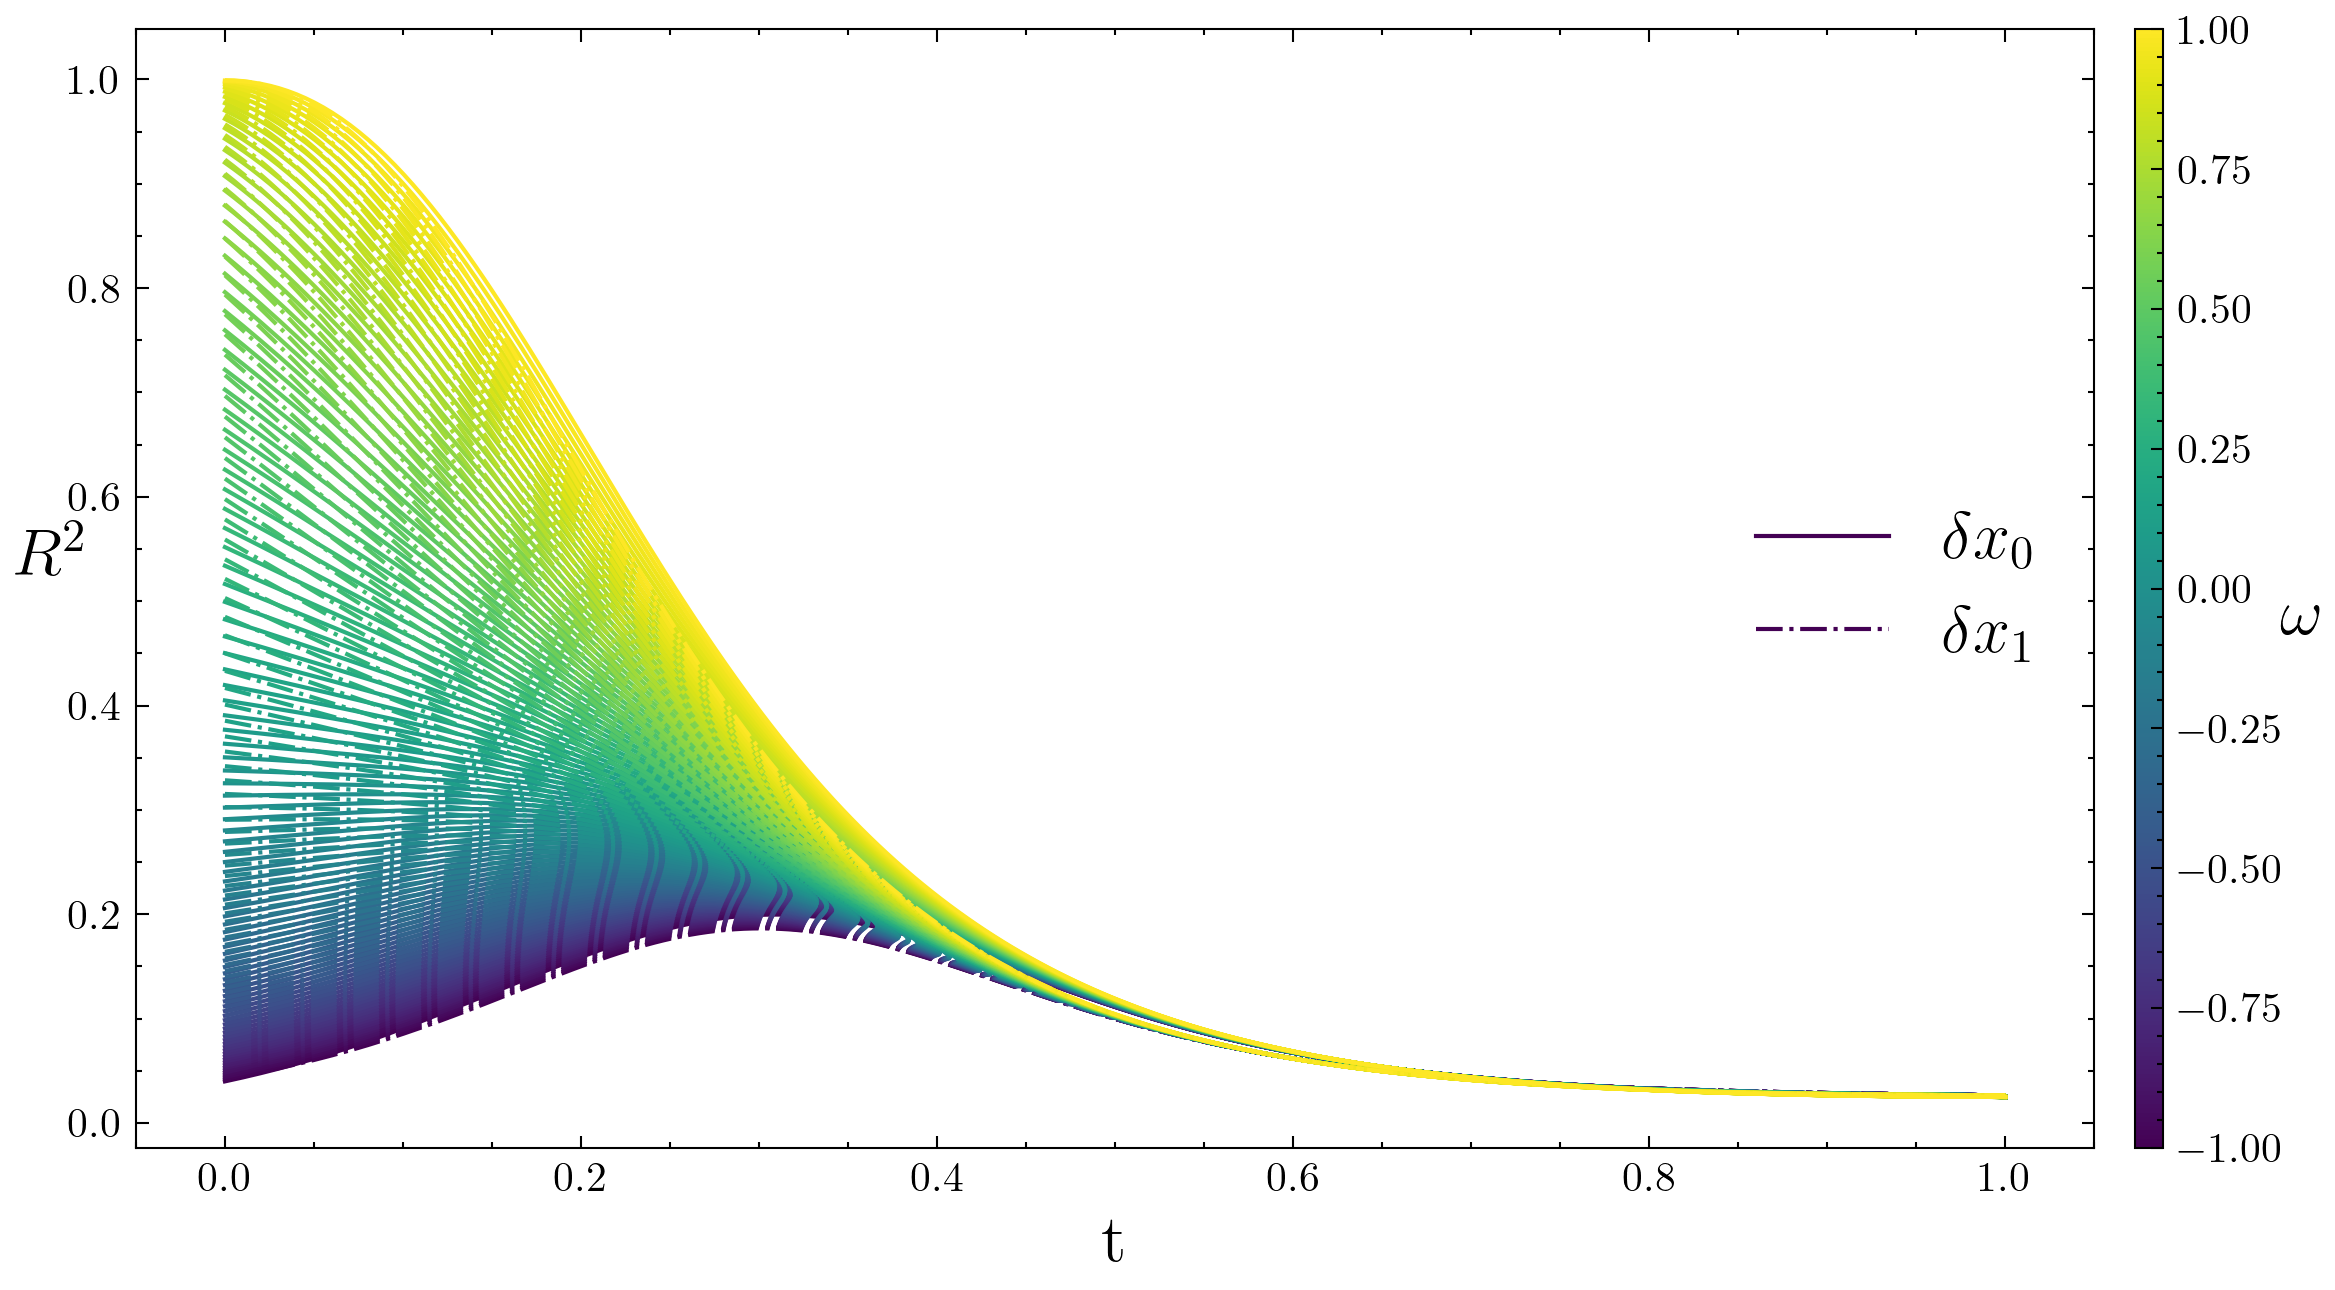

In [39]:
ts = np.linspace(0, 1, n_steps)
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=omegas.min(), vmax=omegas.max())
colors = cmap(norm(omegas))

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)

for k in range(len(omegas)):
    ax.plot(ts, omega_series_dim0[k], color=colors[k])
    ax.plot(ts, omega_series_dim1[k], color=colors[k], linestyle="-.")  # same style

ax.set_xlabel("t", fontsize=16)
ax.set_ylabel("$R^2$", fontsize=16, rotation=0)

ax.legend([r"$\delta{x_0}$", r"$\delta{x_1}$"], fontsize=16, loc="center right")

# Colorbar keyed to omegas
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02, fraction=0.03, aspect=40)
cbar.set_label(r"$\omega$", fontsize=16, rotation=0)

plt.tight_layout()
plt.show()